# Downloading data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

# ==== Paths ====
train_dir = '/content/drive/MyDrive/VGG/train'
val_dir   = '/content/drive/MyDrive/VGG/valid'
test_dir  = '/content/drive/MyDrive/VGG/test'


# ==== Parameters ====
img_size = (64, 64)
train_batch_size = 256
val_batch_size = 256
test_batch_size = 256
seed = 123

# ==== Load Train Dataset (2000 images expected in this folder) ====
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed=seed,
    color_mode='rgb',
    image_size=img_size,
    batch_size=train_batch_size
)

# ==== Load Validation Dataset (50% of test folder) ====
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,

    seed=seed,
    color_mode='rgb',
    image_size=img_size,
    batch_size=val_batch_size
)

# ==== Load Test Dataset (Remaining 50% of test folder) ====
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,

    seed=seed,
    color_mode='rgb',
    image_size=img_size,
    batch_size=test_batch_size
)

# ==== Optional: Prefetch for Performance ====
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

print("✅ Data is ready: 2000 for training, 50% test for validation, 50% test for testing.")


Found 3200 files belonging to 2 classes.
Found 398 files belonging to 2 classes.
Found 402 files belonging to 2 classes.
✅ Data is ready: 2000 for training, 50% test for validation, 50% test for testing.


In [ ]:
# Count total samples in each dataset
train_count = sum(1 for _ in train_ds.unbatch())
val_count = sum(1 for _ in val_ds.unbatch())
test_count = sum(1 for _ in test_ds.unbatch())

print(f"🔢 Training samples: {train_count}")
print(f"🧪 Validation samples: {val_count}")
print(f"🧾 Test samples: {test_count}")


In [ ]:

num_classes=2

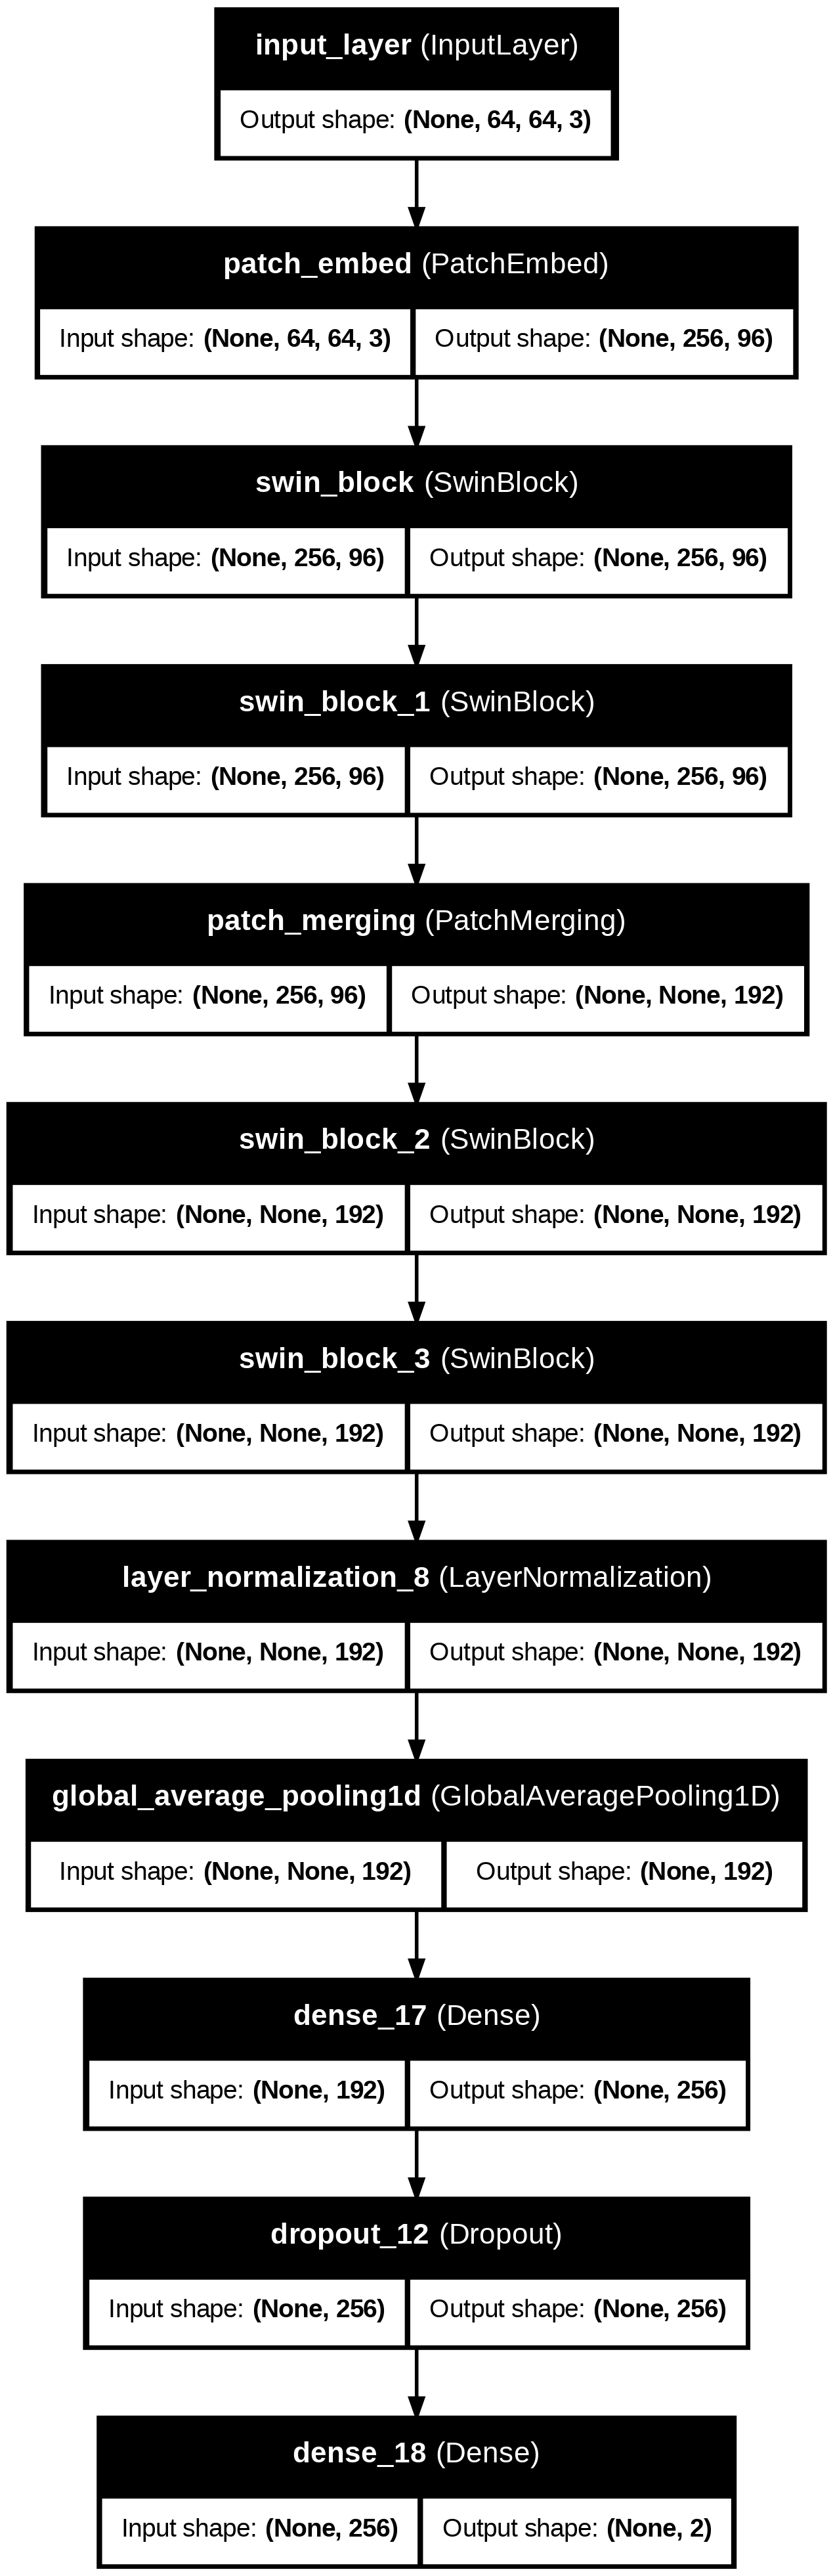

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.utils import plot_model
from IPython.display import Image
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import register_keras_serializable

mixed_precision.set_global_policy('float32')

# ==== Hyperparameters ====
image_size = 64
patch_size = 4
embed_dim = 96
num_classes = 2
window_size = 4
mlp_ratio = 4
depths = [2, 2]
num_heads = [3, 6]

# ==== Window-based Attention ====
@register_keras_serializable()
class WindowAttention(layers.Layer):
    def __init__(self, dim, num_heads, window_size, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3)
        self.proj = layers.Dense(dim)

    def call(self, x):
        B = tf.shape(x)[0]
        N = tf.shape(x)[1]
        C = tf.shape(x)[2]

        qkv = self.qkv(x)
        qkv = tf.reshape(qkv, [B, N, 3, self.num_heads, C // self.num_heads])
        qkv = tf.transpose(qkv, [2, 0, 3, 1, 4])  # (3, B, heads, N, C//heads)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = tf.matmul(q, k, transpose_b=True) * self.scale
        attn = tf.nn.softmax(attn, axis=-1)
        out = tf.matmul(attn, v)
        out = tf.transpose(out, [0, 2, 1, 3])
        out = tf.reshape(out, [B, N, C])
        return self.proj(out)

# ==== Swin Block ====
@register_keras_serializable()
class SwinBlock(layers.Layer):
    def __init__(self, dim, num_heads, window_size, mlp_ratio=4., **kwargs):
        super().__init__(**kwargs)
        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(dim, num_heads, window_size)
        self.drop_path = layers.Dropout(0.1)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = tf.keras.Sequential([
            layers.Dense(int(dim * mlp_ratio), activation='gelu'),
            layers.Dropout(0.1),
            layers.Dense(dim),
            layers.Dropout(0.1)
        ])

    def call(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.attn(x)
        x = self.drop_path(x) + shortcut
        x = x + self.mlp(self.norm2(x))
        return x

# ==== Patch Embedding ====
@register_keras_serializable()
class PatchEmbed(layers.Layer):
    def __init__(self, patch_size=4, embed_dim=96, **kwargs):
        super().__init__(**kwargs)
        self.proj = layers.Conv2D(embed_dim, kernel_size=patch_size, strides=patch_size)
        self.flatten = layers.Reshape((-1, embed_dim))

    def call(self, x):
        x = self.proj(x)
        return self.flatten(x)

# ==== Swin Stage ====
def swin_stage(x, depth, dim, num_heads, window_size):
    for _ in range(depth):
        x = SwinBlock(dim, num_heads, window_size)(x)
    return x

# ==== Patch Merging ====
@register_keras_serializable()
class PatchMerging(layers.Layer):
    def __init__(self, input_resolution, dim, **kwargs):
        super().__init__(**kwargs)
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = layers.Dense(2 * dim, use_bias=False)

    def call(self, x):
        H, W = self.input_resolution
        B = tf.shape(x)[0]

        x = tf.reshape(x, [B, H, W, self.dim])
        x = tf.image.resize(x, size=(H // 2, W // 2), method='bilinear')  # Downsampling
        x = tf.reshape(x, [B, -1, self.dim])
        return self.reduction(x)

# ==== Swin Transformer Builder ====
def build_swin_model():
    inputs = layers.Input(shape=(image_size, image_size, 3))

    # Patch Embedding
    x = PatchEmbed(patch_size=patch_size, embed_dim=embed_dim)(inputs)

    # Stage 1
    H1 = image_size // patch_size
    x = swin_stage(x, depths[0], embed_dim, num_heads[0], window_size)

    # Patch Merging
    x = PatchMerging((H1, H1), embed_dim)(x)
    embed_dim_2 = embed_dim * 2

    # Stage 2
    H2 = H1 // 2
    x = swin_stage(x, depths[1], embed_dim_2, num_heads[1], window_size)


    # Classification head
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(256, activation='gelu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return Model(inputs, outputs, name='MiniSwin')

# ==== Build and Plot ====
swin_model = build_swin_model()
plot_model(
    swin_model,
    to_file='swin_model.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB'
)
Image('swin_model.png')


In [ ]:
# Save and print model summary
with open("model_summary.txt", "w") as f:
    swin_model.summary(print_fn=lambda x: f.write(x + "\n"))
swin_model.summary()

Model: "MiniSwin"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_embed (PatchEmbed)        │ (None, 256, 96)        │         4,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swin_block (SwinBlock)          │ (None, 256, 96)        │       111,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swin_block_1 (SwinBlock)        │ (None, 256, 96)        │       111,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ patch_merging (PatchMerging)    │ (None, None, 192)      │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swin_block_2 (SwinBlock)        │ (None, None, 192)      │       444,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ swin_block_3 (SwinBlock)        │ (None, None, 192)      │       444,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_8           │ (None, None, 192)      │           384 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 192)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 256)            │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,186,850 (4.53 MB)

 Trainable params: 1,186,850 (4.53 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ==== Compile & Callbacks for Swin Transformer ====

best_model_ckpt_path = 'best_swin_model.keras'  # ✅ Recommended extension for saving full models in TF 2.x

# Compile the Swin model
swin_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=[
        tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')
    ]
)

#  Model Checkpoint: saves the best model based on validation loss
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=best_model_ckpt_path,
    save_weights_only=False,     # Save full model, not just weights
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

#  CSV Logger: logs training progress to CSV file
csv_logger_callback = tf.keras.callbacks.CSVLogger(
    filename='swin_training_log.csv',  # Updated filename for clarity
    separator=',',
    append=False
)

print("✅ Swin model compiled and callbacks are set up.")


✅ Swin model compiled and callbacks are set up.


## Start training and validating results

In [ ]:
n_epoch = 200

In [ ]:
# ==== Training Swin Transformer Model ====
import time

n_epoch = 200
print("🟢 Training Swin Transformer Classifier:\n")

start_time = time.time()

# ⚠️ Make sure `train_ds`, `val_ds`, and `class_weights` are already defined

history = swin_model.fit(
    train_ds,
    validation_data=val_ds,

    epochs=n_epoch,
    callbacks=[checkpoint_callback, csv_logger_callback]
)

model_time = time.time() - start_time
print(f" Training completed. Total time = {model_time:.2f} seconds")


🟢 Training Swin Transformer Classifier:

Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.4972 - loss: 0.7399 
Epoch 1: val_loss improved from inf to 0.69919, saving model to best_swin_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 611s 43s/step - accuracy: 0.4970 - loss: 0.7399 - val_accuracy: 0.4975 - val_loss: 0.6992
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5058 - loss: 0.7173
Epoch 2: val_loss improved from 0.69919 to 0.69424, saving model to best_swin_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.5057 - loss: 0.7173 - val_accuracy: 0.5025 - val_loss: 0.6942
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5181 - loss: 0.7088
Epoch 3: val_loss improved from 0.69424 to 0.69380, saving model to best_swin_model.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.5175 - loss: 0.7087 - val_accuracy: 0.5025 - val_loss: 0.6938
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4957 - loss: 0.7094
Epoch 4:

In [ ]:
01# Save the trained model
swin_model.save('best_swin_model.keras')


In [ ]:
# Load the best model later
best_model = tf.keras.models.load_model('best_swin_model.keras')

print("✅ Best Swin model loaded successfully.")


✅ Best Swin model loaded successfully.


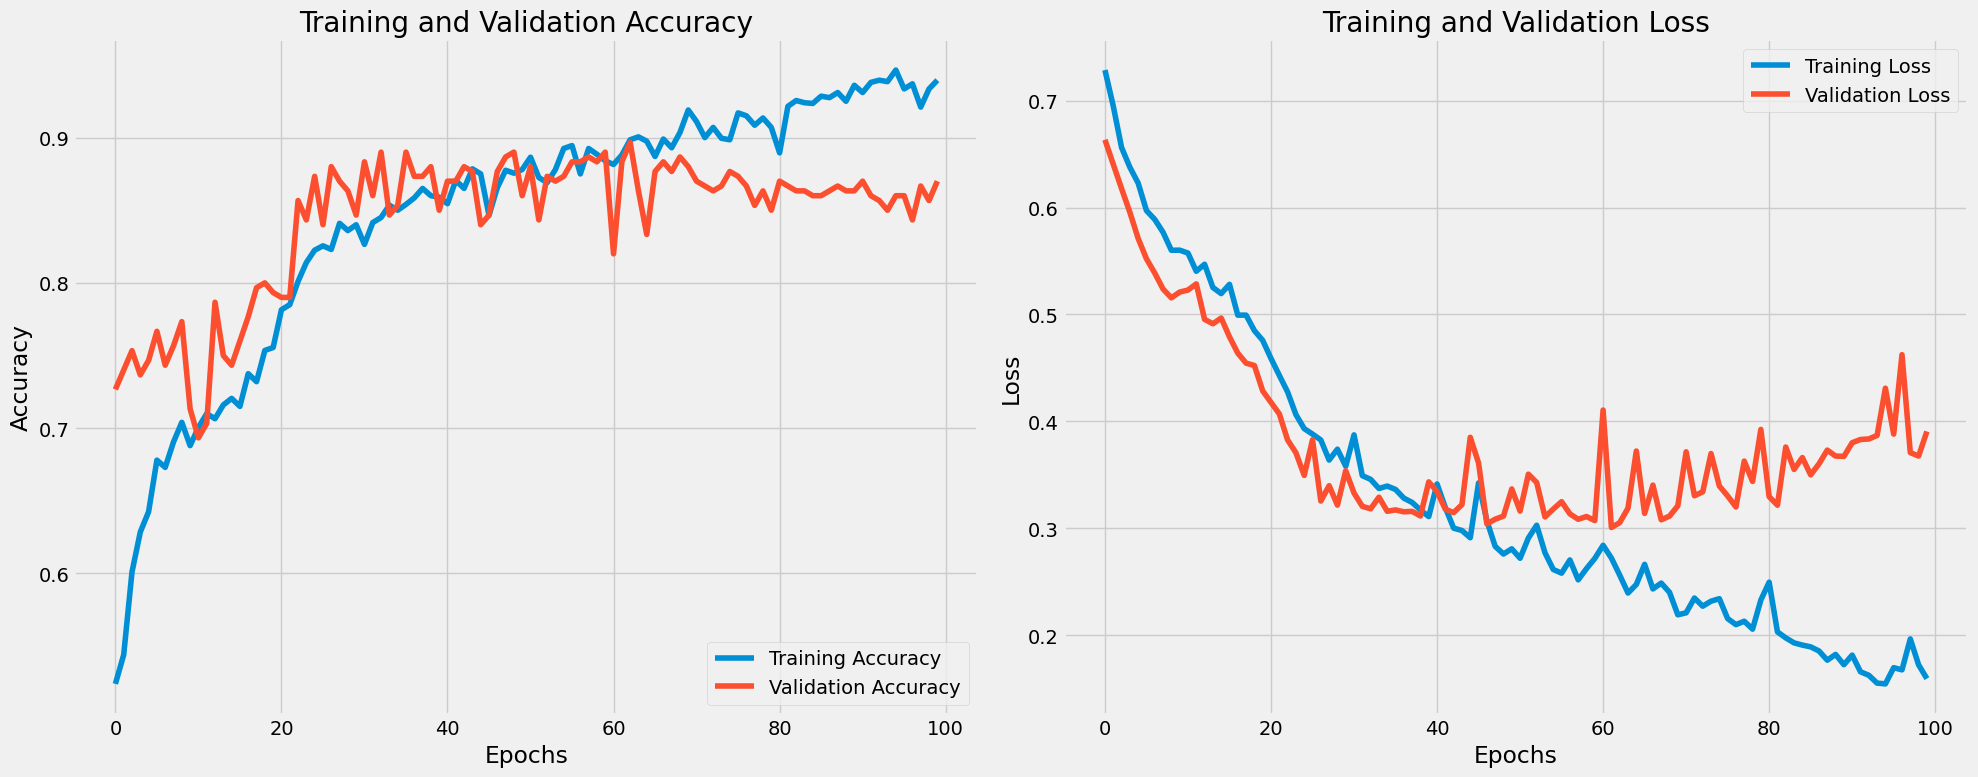

In [ ]:
import matplotlib.pyplot as plt

# Extract metrics from ViT training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(n_epoch)

plt.figure(figsize=(20, 8))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
# Replace test_ds with your test dataset
test_loss, test_accuracy = best_model.evaluate(test_ds, verbose=1)

print(f"\n📊 Test Loss: {test_loss:.4f}")
print(f"✅ Test Accuracy: {test_accuracy:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8153 - loss: 0.6051 

📊 Test Loss: 0.5979
✅ Test Accuracy: 0.8167
